In [99]:
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import yt
import glob
import pandas as pd
import math
import scipy.integrate as integrate
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 400

In [3]:
def tophat(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 0.5 * width):
        return amplitude
    else:
        return 0.0

In [4]:
def gaussian(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return amplitude * math.exp( - ((x - convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [5]:
def yalla2021(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return math.cos(eta * (x-convected_distance)) * amplitude * math.exp( - ((x-convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [6]:
def tophatfv(func,x,dx,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs(abs((x-convected_distance) - center) - width / 2) < dx / 2) :
        return amplitude * (width / 2 - abs((x-convected_distance) - center) + dx / 2) / dx
    elif (abs((x-convected_distance) - center) < width / 2) :
        return amplitude
    else :
        return 0.0

In [7]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [8]:
def exact_sol_cell_average_scipy(func,x,dx,center,amplitude,width,eta,t) :
    integral = integrate.quad(func,x-dx/2,x+dx/2,args=(center,amplitude,width,eta,t))
    return integral[0]/dx

In [9]:
def exact_sol_cell_average_GLQ(func,x,dx,center,amplitude,width,eta,t) :
    w_i = [0.5555555556, 0.8888888889, 0.5555555556]
    dx_i = [-0.7745966692, 0, 0.7745966692]
    s = 0.0
    for i in range(len(w_i)) :
        s += w_i[i] * func(x + dx_i[i]*dx/2, center, amplitude, width, eta, t)
    return s/2

In [6]:
center = 0.25
amplitude = 1.0
width = 0.0251646060
# width = 0.05
# width = 0.01
eta = 226.1946710304
t_final = 0.5
Lx = 1.0
function = yalla2021

In [11]:
root_dir = '/home/dbeckers/tests/scalar_advection'

In [15]:
color_list = [
    "#EE2E2F",
    "#008C48",
    "#185AA9",
    "#F47D23",
    "#662C91",
    "#A21D21",
    "#B43894",
    "#010202",
]
linestyle_list = [
    "solid",
    "dashed",
    "dotted",
    "dashdot"
]
linewidth_list = [
    1.5,
    0.5
]

In [142]:
def postprocess_dist(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,line_configuration):
    
    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                # Load plt files
                plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
                
                ds = yt.load(plt_files[idx])
                ray = ds.ortho_ray(0, (0, 0))
                srt = np.argsort(ray["x"])
                df = pd.DataFrame({f: np.array(ray[f][srt]) for f in ["x","temperature"]})
                t = ds.current_time.value.flatten()[0]
                df["time"] = t
                df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]
                
                # Plot scalar distribution
                if line_configuration == 1:
                    ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                else:
                    ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
                     
            

In [70]:
def postprocess_error(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths):
    
    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'error.log')
                with open(error_file) as f:
                    lines = f.readlines()
                    error_levels = len(lines[1].split())-1
                    time = [float(line.split()[0]) for line in lines]
                    for level in reversed(range(error_levels)):
                        error = [float(line.split()[level+1]) for line in lines]
                        ax.plot(time, error, color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method], label=f'{method}; nx = {grid_size}; grid type = {grid_type}')
            

In [77]:
def postprocess_convergence(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths):
    
    dx_list = [1.0/grid_size for grid_size in grid_sizes]

    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            
            error_list = []
            
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'error.log')
                
                with open(error_file) as f:
                    lines = f.readlines()
                    error = float(lines[-1].split()[-1])
                    
                error_list.append(error)
                
        ax.plot(dx_list, error_list,linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color='black',label=f'{method}; grid type = {grid_type}')
                

# Animation to show scalar advection case

In [102]:
center = 0.25
amplitude = 1.0
width = 0.0251646060
# width = 0.05
# width = 0.01
eta = 226.1946710304
# t_final = 0.5
function = yalla2021

In [139]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 20

fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-1.3, 1.3))
line, = ax.plot([], [], color='red',linewidth=1)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    t = i/(n_frames-1)*0.5
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    line.set_data(x_exact, scalar_exact)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=100, blit=True)

In [140]:
anim

# Uniform grid: different methods with nx = 512

### Initial timestep

In [148]:
lw_exact = 0.5
ls_exact = 'dashed'

yt : [INFO     ] 2022-08-06 22:43:58,861 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-06 22:43:58,862 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 22:43:58,862 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 22:43:58,863 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-06 22:44:00,380 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-06 22:44:00,381 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 22:44:00,382 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 22:44:00,383 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-06 22:44:01,892 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-06 22:44:01,893 Parameters: domain_dimensions         = [512

(-1.0, 1.3)

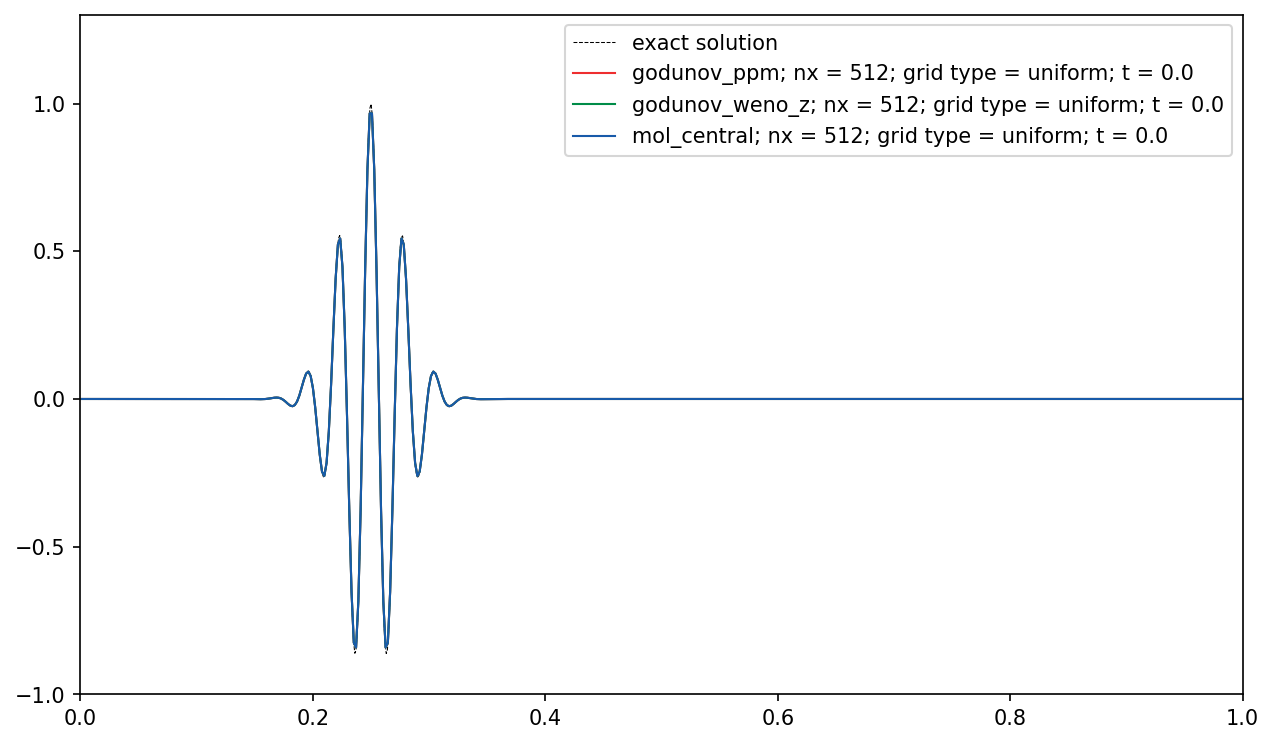

In [150]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',0,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],2)

ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])

### Final timestep

yt : [INFO     ] 2022-08-06 22:44:18,796 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 22:44:18,796 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 22:44:18,797 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 22:44:18,797 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]


(-1.0, 1.3)

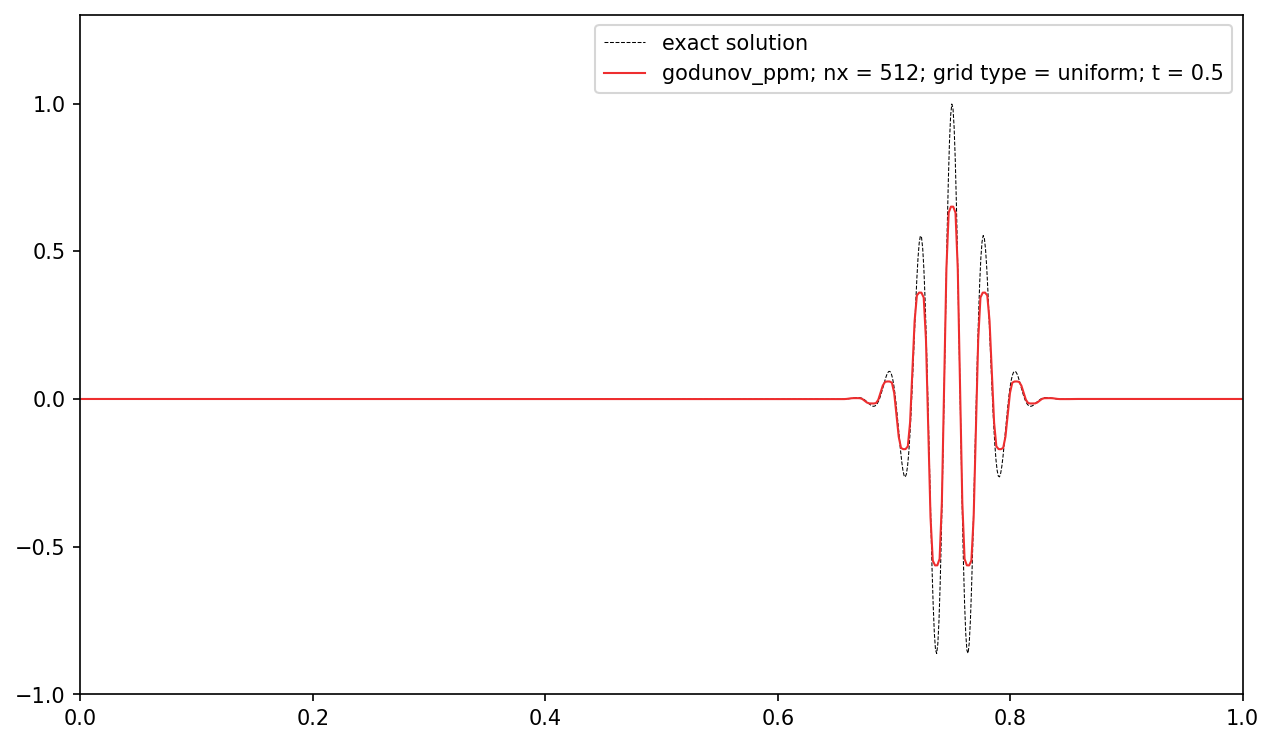

In [151]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],2)

ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])

yt : [INFO     ] 2022-08-06 22:44:27,049 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 22:44:27,050 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 22:44:27,051 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 22:44:27,052 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-06 22:44:28,516 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 22:44:28,517 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 22:44:28,518 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 22:44:28,519 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]


(-1.0, 1.3)

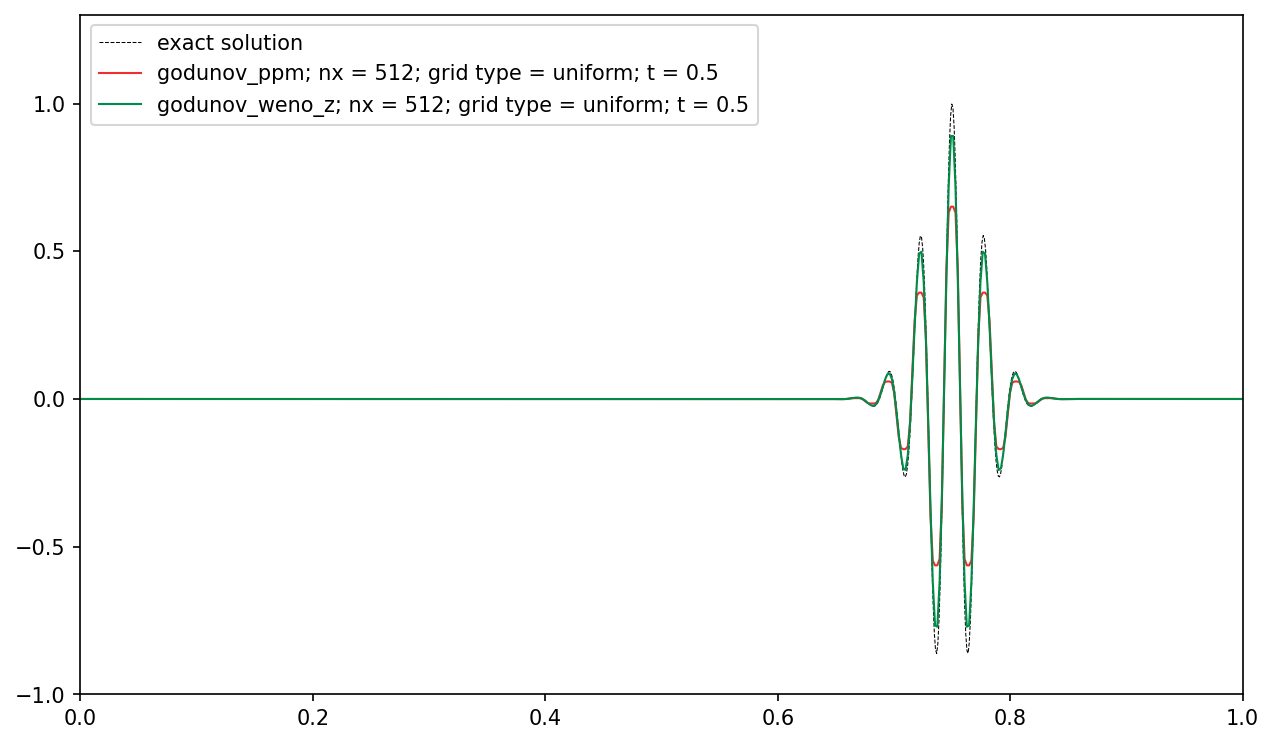

In [152]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],2)

ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])

yt : [INFO     ] 2022-08-06 22:44:52,662 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 22:44:52,663 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 22:44:52,663 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 22:44:52,664 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-06 22:44:53,996 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 22:44:53,997 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-06 22:44:53,998 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-06 22:44:53,998 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-06 22:44:55,303 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-06 22:44:55,303 Parameters: domain_dimensions         = [512

(-1.0, 1.3)

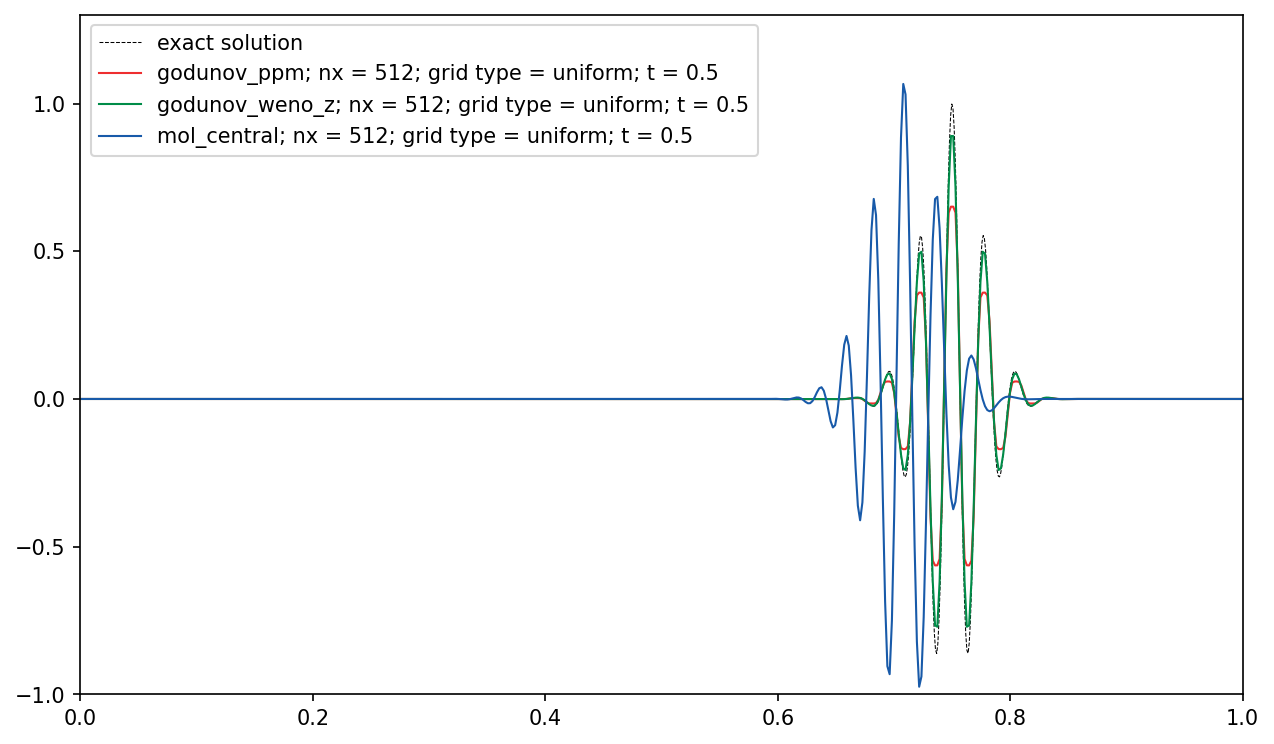

In [154]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],2)

ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])

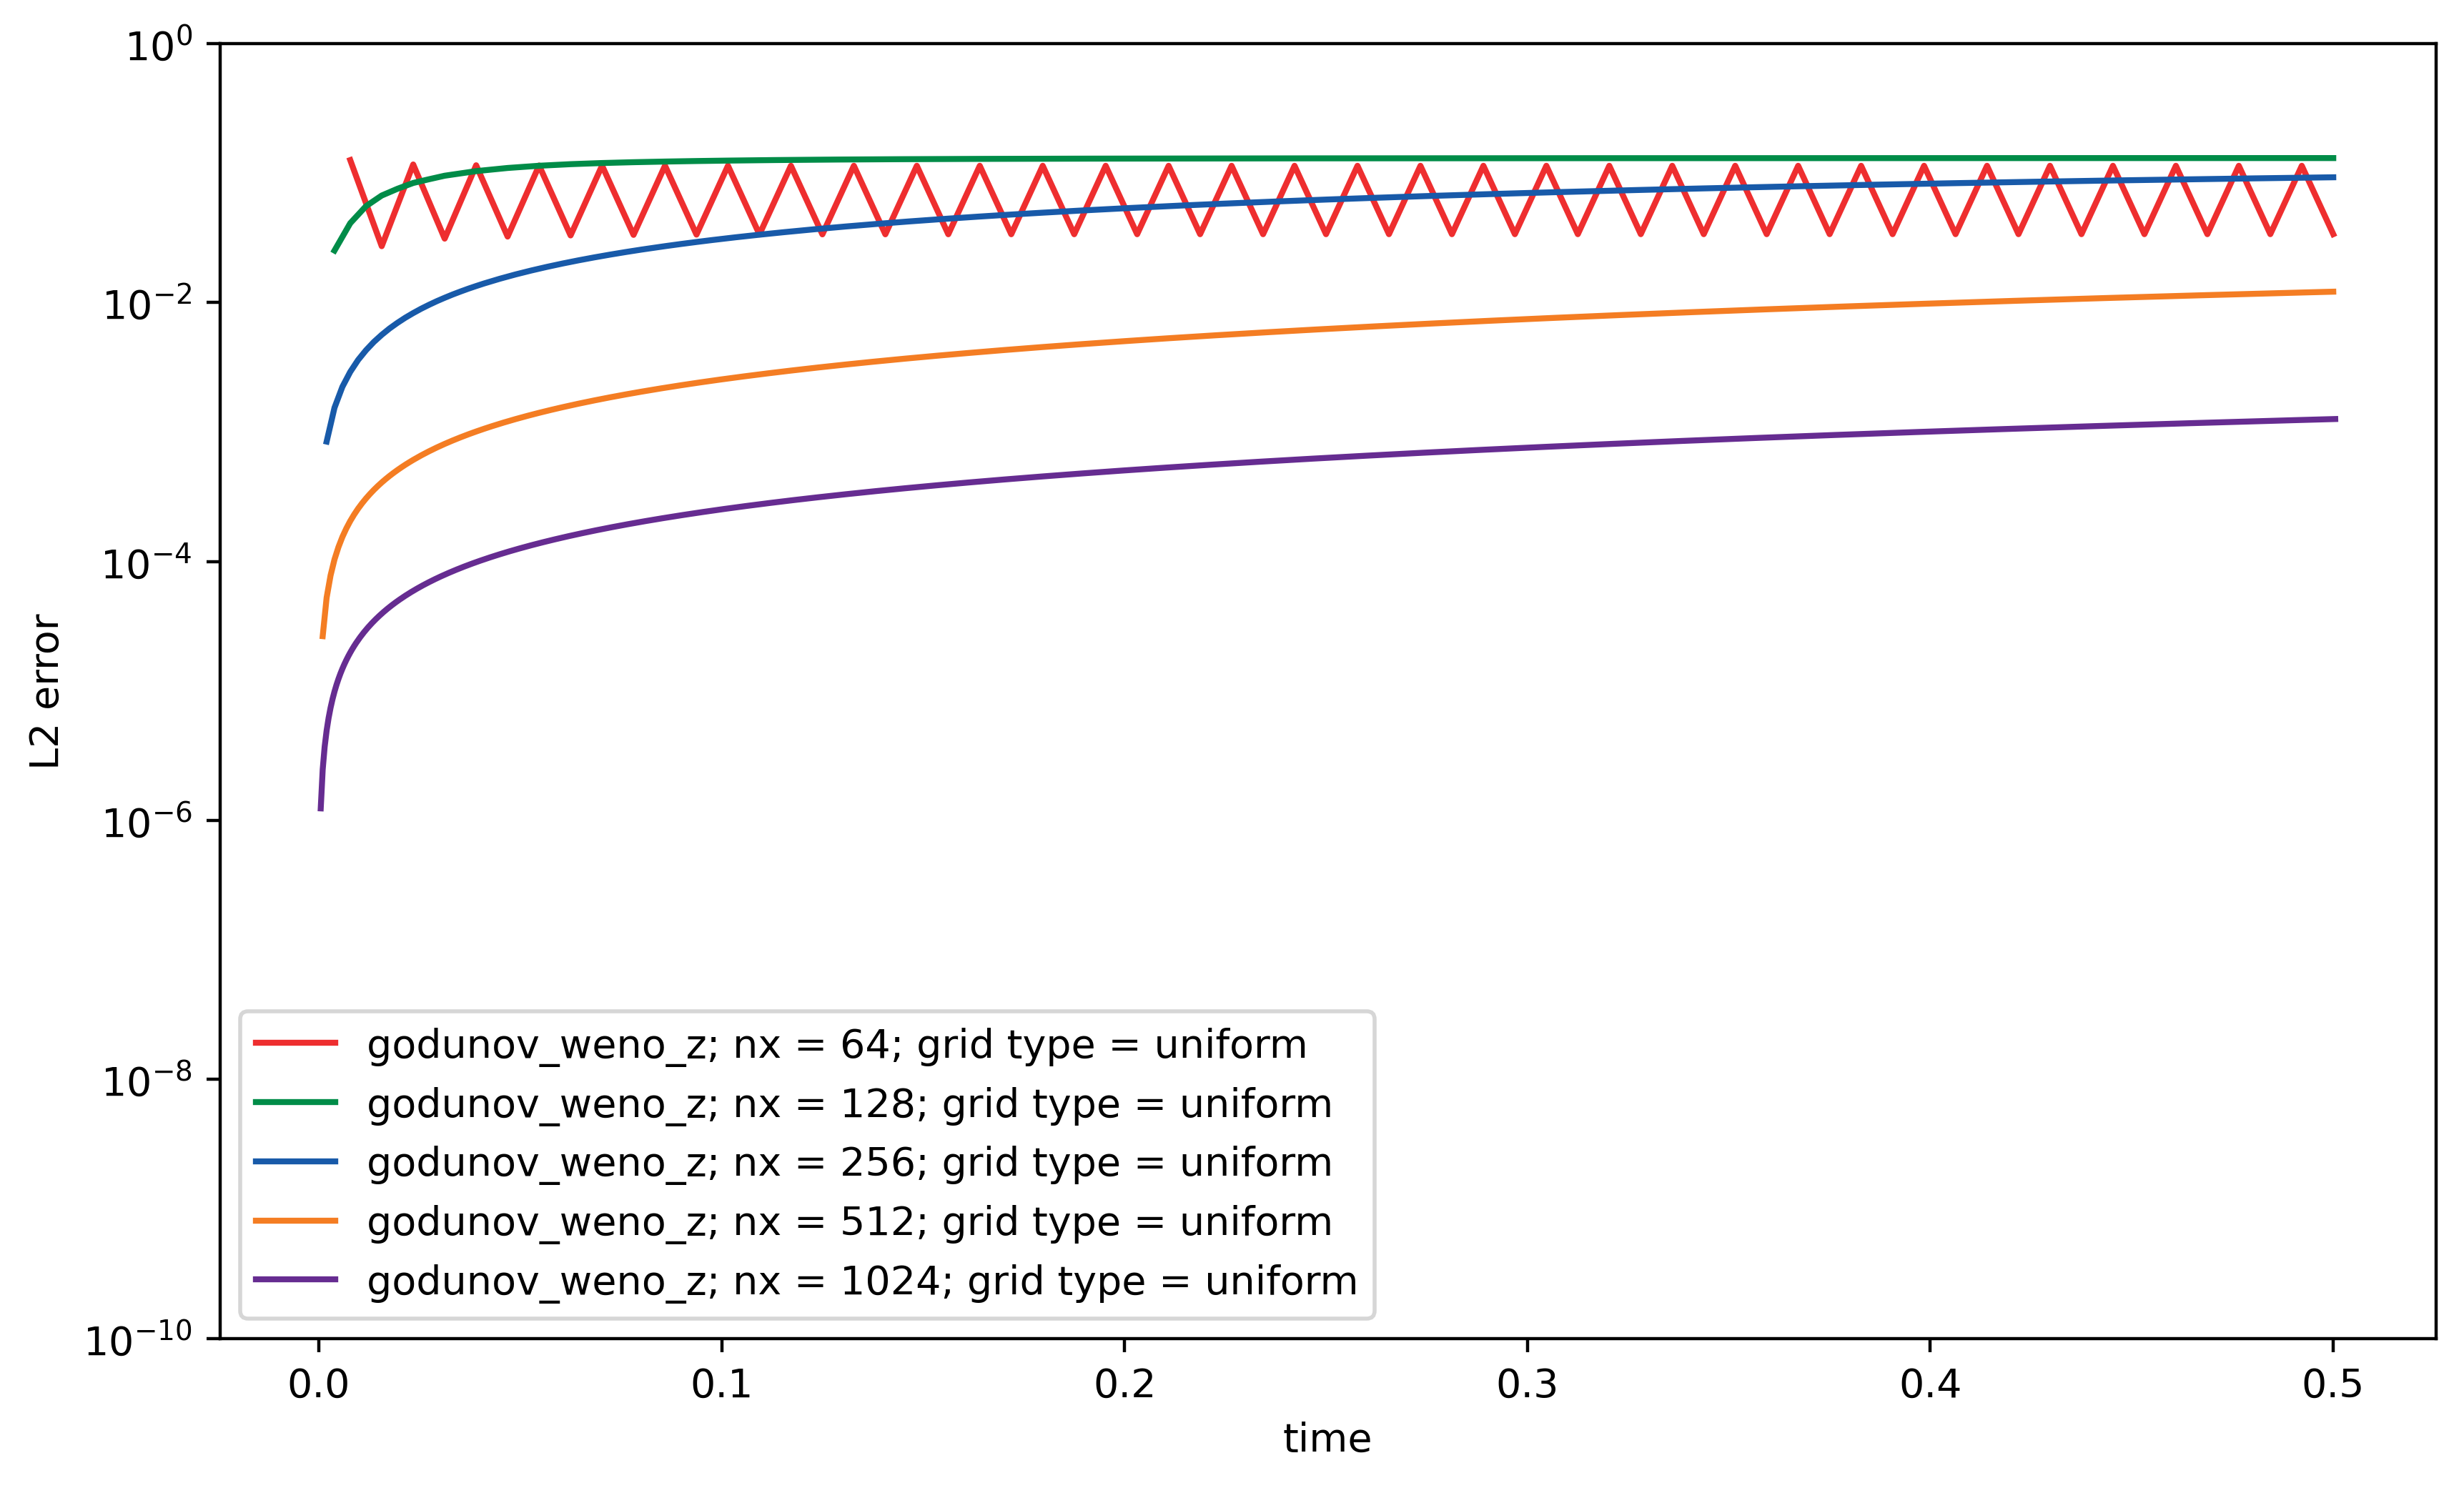

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0,root_dir,['godunov_weno_z'],['uniform'],[64,128,256,512,1024],
                 ax,linestyle_list,color_list,linewidth_list)

ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-10,1])
ax.set_yscale('log')

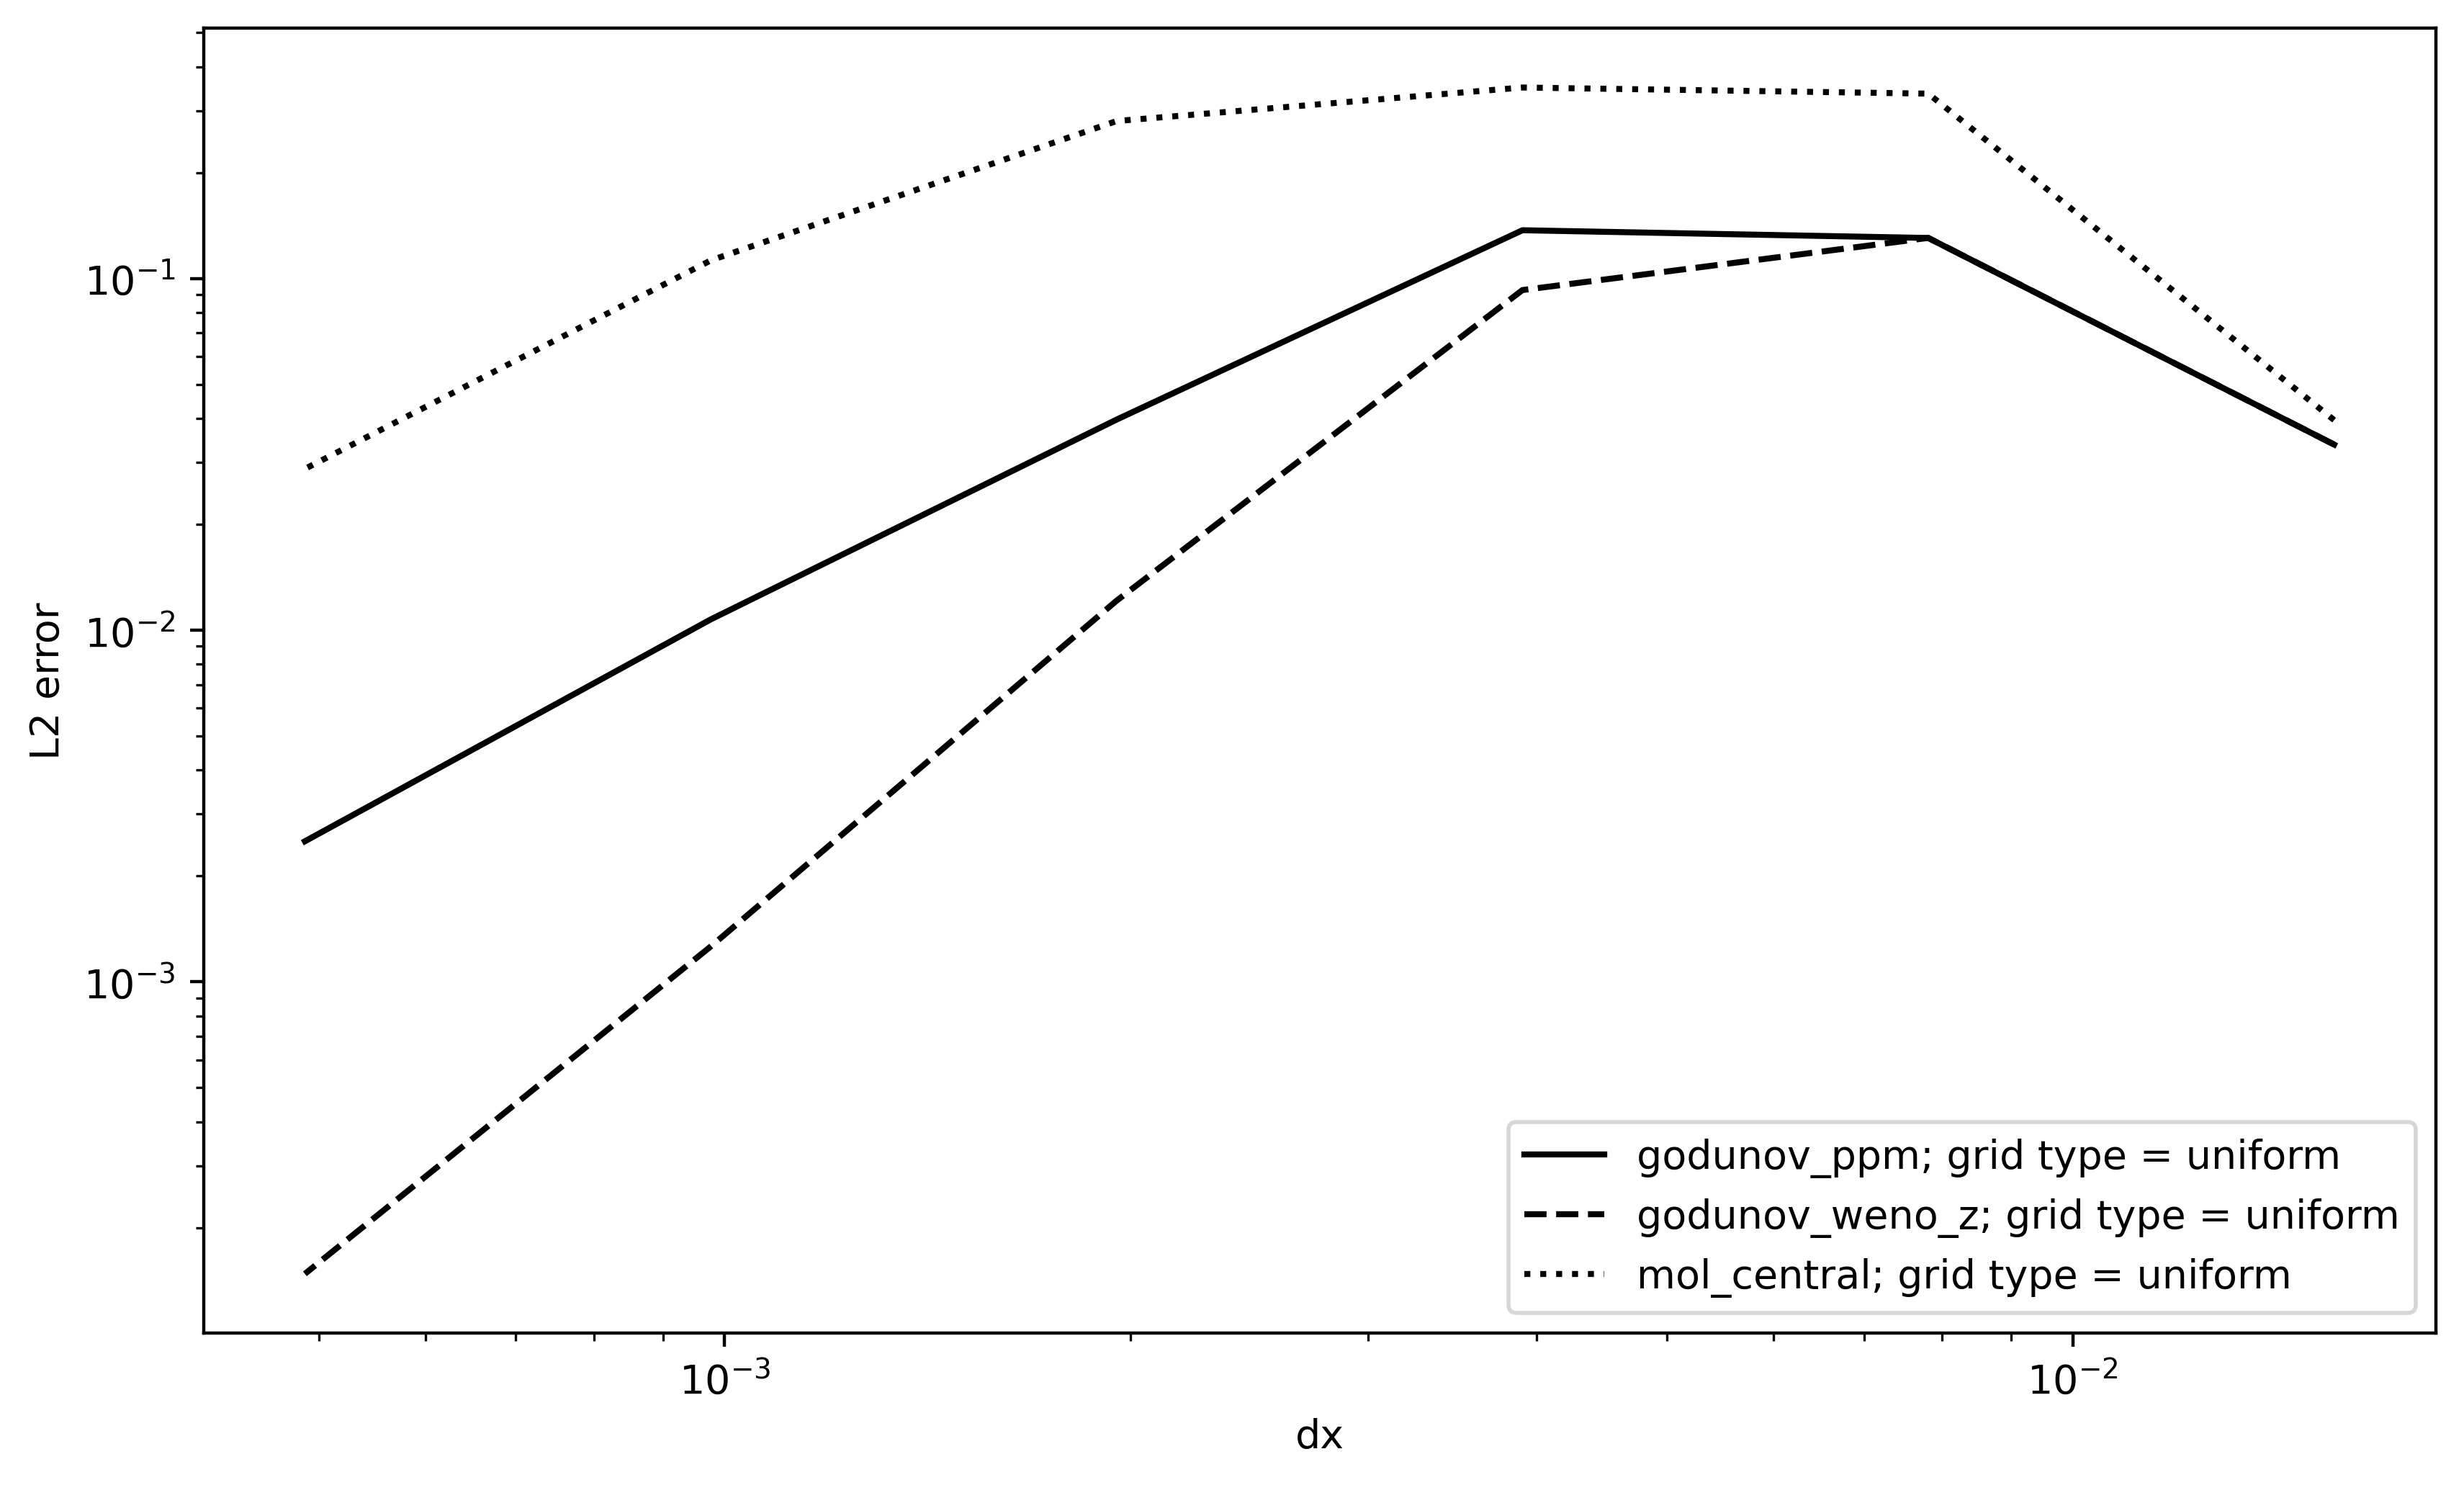

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_convergence('yalla2021/eta_2',0,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[64,128,256,512,1024,2048],
                 ax,linestyle_list,color_list,linewidth_list)

ax.legend()
ax.set_xlabel('dx')
ax.set_ylabel('L2 error')
ax.set_xscale('log')
ax.set_yscale('log')